### Loading and PreProcessing

In [2]:
# Loading the data

import pandas as pd

df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,sentence,label
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,sentence
1,1,"Born and raised in Houston, Texas, she perform...",sentence
2,2,"Managed by her father, Mathew Knowles, the gro...",sentence
3,3,Their hiatus saw the release of Beyoncé's debu...,sentence
4,4,Following the disbandment of Destiny's Child i...,sentence


In [3]:
#Cleaning the  data
import re
import spacy

filter = df["sentence"] != ""
df = df[filter]
df = df.dropna()

def clean(sen):
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

lemmas = []
sentences = list(df["sentence"])
for sen in sentences:
    lemmas.append(clean(sen).lower())
    



### Text Vectorization

In [12]:
#tfidf

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
tfvector = TfidfVectorizer(max_features = 1000)
wordbag = tfvector.fit_transform(lemmas)

In [13]:
#Count Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
countvectorizer = CountVectorizer(analyzer='word', min_df=10,lowercase=True,token_pattern='[a-zA-Z0-9]{3,}')
countvector = countvectorizer.fit_transform(lemmas)


In [14]:
#LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
svd = TruncatedSVD(n_components=200)
lsa = svd.fit_transform(wordbag.T)
svdvector= svd.components_.T

scaler = MinMaxScaler()
svdscaled = scaler.fit_transform(svdvector)

In [ ]:
svdscaled.shape

In [15]:
#LDA
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=100,random_state = 23)
ldavec = lda.fit_transform(countvector)

In [16]:
# One-word embedding
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

tokenized_data = []
for text in lemmas:
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in my_stopwords]
    tokenized_data.append(filtered_tokens)


model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, sg=1)



In [17]:
def get_sentence_vector(sentence):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

embedded = np.array([get_sentence_vector(sentence) for sentence in lemmas])

embedscaled = scaler.fit_transform(embedded)


In [ ]:
# one sentence embedding
from sentence_transformers import SentenceTransformer

sentencemodel = SentenceTransformer('paraphrase-MiniLM-L6-v2')
senvec = sentencemodel.encode(lemmas)

In [ ]:
#Function incorporating all vectors

def vectorizer(df, vtype): # 0:tfidf, 1:lsa, 2:lda, 3:word embedding, 4 : sentence embedding 
    df = pd.read_csv("data.csv")

    filter = df["sentence"] != ""
    df = df[filter]
    df = df.dropna()

    def clean(sen):
        sentence = re.sub('[^a-zA-Z]', ' ', sen)
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        
        return sentence

    lemmas = []
    sentences = list(df["sentence"])
    for sen in sentences:
        lemmas.append(clean(sen).lower())

    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    my_stopwords = stopwords.words('english')

    if vtype == 0 :
        import sklearn
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfvector = TfidfVectorizer(stop_words = my_stopwords,max_features = 1000)
        wordbag = tfvector.fit_transform(lemmas)
        return wordbag
    
    if vtype == 1 :
        from sklearn.decomposition import TruncatedSVD
        from sklearn.preprocessing import MinMaxScaler
        svd = TruncatedSVD(n_components=200)
        lsa = svd.fit_transform(wordbag.T)
        svdvector= svd.components_.T

        scaler = MinMaxScaler()
        svdscaled = scaler.fit_transform(svdvector)
        return svdscaled
    
    if vtype == 2:
        from sklearn.decomposition import LatentDirichletAllocation
        lda = LatentDirichletAllocation(n_components=100,random_state = 23)
        ldavec = lda.fit_transform(wordbag)

        return ldavec
    
    if vtype ==3:
        from gensim.models import Word2Vec
    from nltk.tokenize import word_tokenize
    import numpy as np

    tokenized_data = []
    for text in lemmas:
        tokens = word_tokenize(text.lower())
        filtered_tokens = [word for word in tokens if word not in my_stopwords]
        tokenized_data.append(filtered_tokens)


    model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, sg=1)
    def get_sentence_vector(sentence):
        word_vectors = [model.wv[word] for word in sentence if word in model.wv]
        if len(word_vectors) == 0:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)

    embedded = np.array([get_sentence_vector(sentence) for sentence in lemmas])

    embedscaled = scaler.fit_transform(embedded)
    return embedscaled

    if vtype ==4:
        from sentence_transformers import SentenceTransformer

        sentencemodel = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        senvec = sentencemodel.encode(lemmas)
        return senvec




### Applying Models

In [10]:
mapping = {"sentence":0, "question":1}
y = df["label"].replace(mapping)
answers = y.tolist()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import sklearn.naive_bayes
import matplotlib.pyplot as plt

In [18]:
# Applying models

def applymodel(vectortype):
        x_train, x_test, y_train, y_test = train_test_split(vectortype, answers, test_size=0.20, random_state=42)
        
        lr = LogisticRegression(max_iter = 10000)
        lr.fit(x_train,y_train)
        lr_probs = lr.predict_proba(x_test)[:, 1]
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        lr_auc = auc(lr_fpr, lr_tpr)
        lr_pred = lr.predict(x_test)
        lr_acc = accuracy_score(y_test,lr_pred)
    
        dt = DecisionTreeClassifier(max_depth=50)
        dt.fit(x_train,y_train)
        dt_probs = dt.predict_proba(x_test)[:, 1]
        dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
        dt_pred = dt.predict(x_test)
        dt_auc = auc(dt_fpr, dt_tpr)
        dt_acc = accuracy_score(y_test,dt_pred)
        
        rf = RandomForestClassifier(max_depth=15, n_estimators=40)
        rf.fit(x_train,y_train)
        rf_probs = rf.predict_proba(x_test)[:, 1]
        rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
        rf_auc = auc(rf_fpr, rf_tpr)
        rf_pred = rf.predict(x_test)
        rf_acc = accuracy_score(y_test,rf_pred)
        
        clf = MultinomialNB()
        clf.fit(x_train, y_train)
        clf_probs = clf.predict_proba(x_test)[:, 1]
        clf_fpr, clf_tpr, _ = roc_curve(y_test, clf_probs)
        clf_auc = auc(clf_fpr, clf_tpr)
        clf_pred = clf.predict(x_test)
        clf_acc = accuracy_score(y_test,clf_pred)
        
        
        plt.figure(figsize=(10, 6))
        plt.plot(lr_fpr, lr_tpr, color="yellow",label=f'Logistic Regression (AUC = {lr_auc:.2f})')
        plt.plot(rf_fpr, rf_tpr, color='green', label=f'Random Forest (AUC = {rf_auc:.2f})')
        plt.plot(dt_fpr, dt_tpr, color='red', label=f'Decison Tree (AUC = {dt_auc:.2f})')
        plt.plot(clf_fpr, clf_tpr, color='black', label=f'Naive Bayes (AUC = {clf_auc:.2f})')


        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [ ]:
def lstm():

    df['clean'] = df['sentence'].apply(clean)

    X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['label'], test_size=0.2, random_state=42)


    label_map = {'question': 1, 'sentence': 0}
    y_train_binary = y_train.map(label_map)
    y_test_binary = y_test.map(label_map)

    max_words = 5000  
    max_len = 150

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    sequences = tokenizer.texts_to_sequences(X_train)
    X_train_lstm = pad_sequences(sequences, maxlen=max_len)

    sequences = tokenizer.texts_to_sequences(X_test)
    X_test_lstm = pad_sequences(sequences, maxlen=max_len)

    model_lstm = Sequential()
    model_lstm.add(Embedding(max_words, 32, input_length=max_len))
    model_lstm.add(LSTM(32))
    model_lstm.add(Dense(1, activation='sigmoid'))

    model_lstm.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['acc'])
    history = model_lstm.fit(X_train_lstm, y_train_binary, epochs=5, batch_size=128, validation_split=0.2, verbose=0)

    y_prob_lstm = model_lstm.predict(X_test_lstm).ravel()


    fpr_lstm, tpr_lstm, _ = roc_curve(y_test_binary, y_prob_lstm)
    roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

    plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()



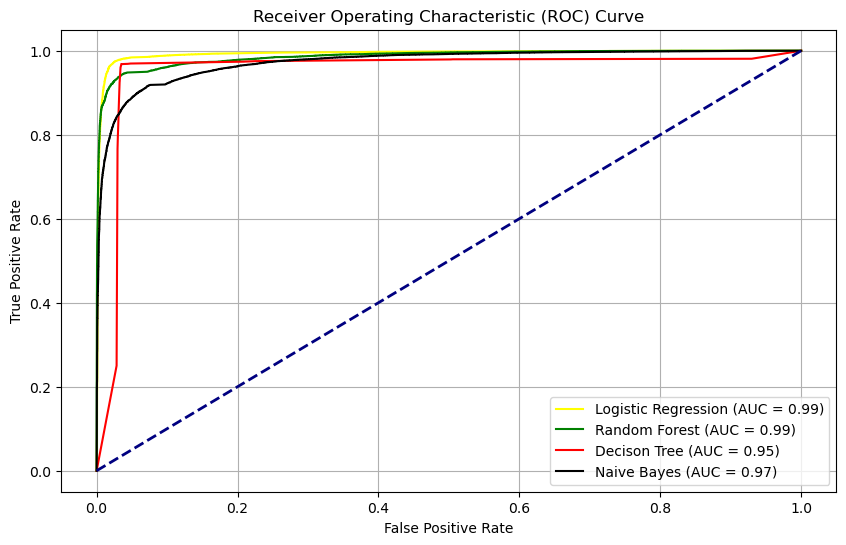

In [19]:
#tfidf
applymodel(wordbag)

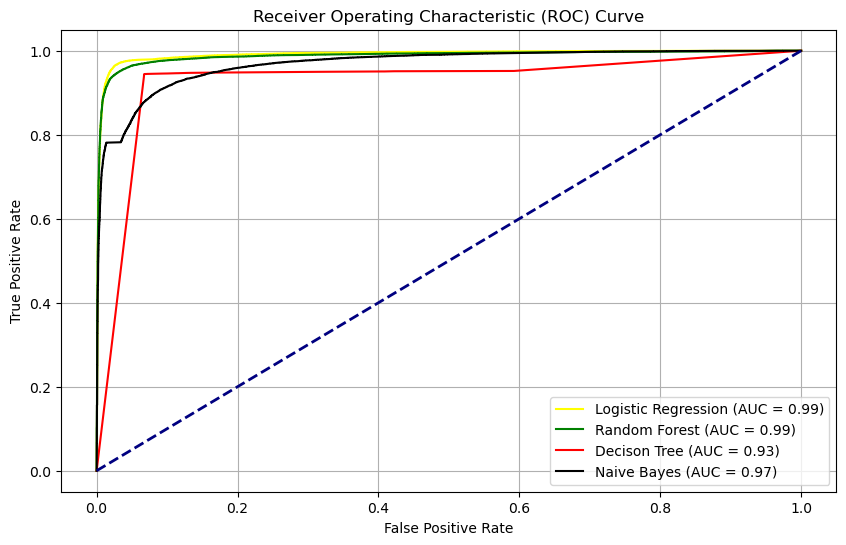

In [20]:
#lsa
applymodel(svdscaled)

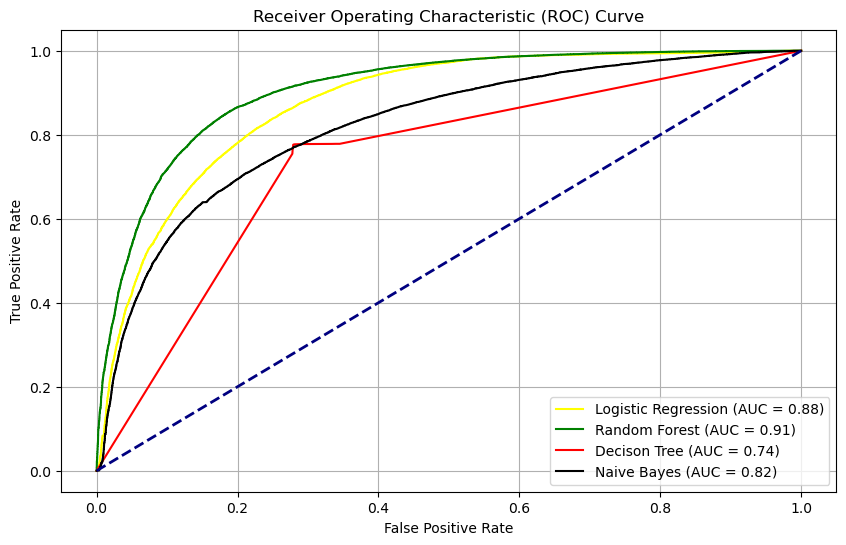

In [21]:
#one word embedding
applymodel(embedscaled)

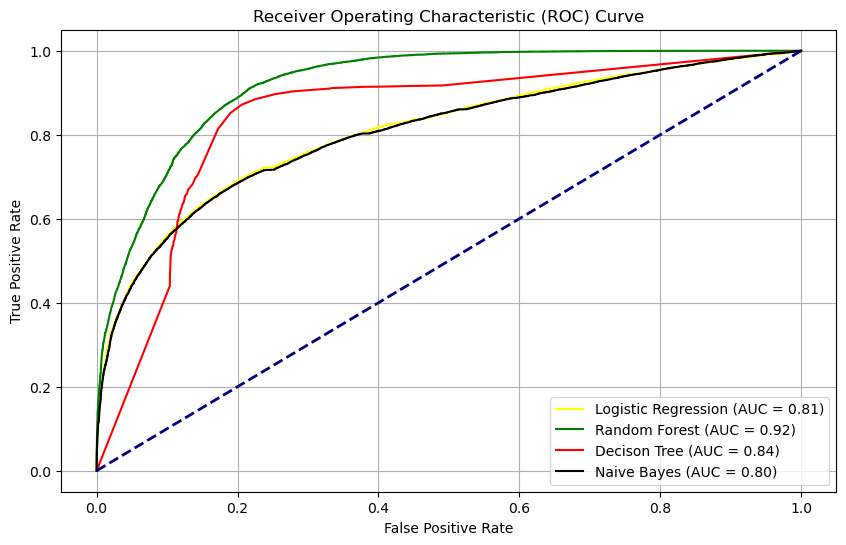

In [22]:
#lda
applymodel(ldavec)

In [ ]:
#lstm
lstm()

## REStful API

In [ ]:
# Download watchdog and then run, preferably from cmd

from flask import Flask, request
from flask_restful import Resource, Api
import pandas as pd
from flask import jsonify
import re


app = Flask(__name__)
api = Api(app)

def vectorizer(df, vtype): # 0:tfidf, 1:lsa, 2:lda, 3:word embedding, 4 : sentence embedding 
    df = pd.read_csv(df)

    mapping = {"sentence":0, "question":1}
    y = df["label"].replace(mapping)
    answers = y.tolist()

    filter = df["sentence"] != ""
    df = df[filter]
    df = df.dropna()

    def clean(sen):
        sentence = re.sub('[^a-zA-Z]', ' ', sen)
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        
        return sentence

    lemmas = []
    sentences = list(df["sentence"])
    for sen in sentences:
        lemmas.append(clean(sen).lower())

    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    my_stopwords = stopwords.words('english')

    if vtype == "0" :
        import sklearn
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfvector = TfidfVectorizer(stop_words = my_stopwords,max_features = 1000)
        wordbag = tfvector.fit_transform(lemmas)
        return wordbag, answers
    
    if vtype == "1" :
        from sklearn.decomposition import TruncatedSVD
        from sklearn.preprocessing import MinMaxScaler
        svd = TruncatedSVD(n_components=200)
        lsa = svd.fit_transform(wordbag.T)
        svdvector= svd.components_.T

        scaler = MinMaxScaler()
        svdscaled = scaler.fit_transform(svdvector)
        return svdscaled,answers
    
    if vtype == "2":
        from sklearn.decomposition import LatentDirichletAllocation
        lda = LatentDirichletAllocation(n_components=100,random_state = 23)
        ldavec = lda.fit_transform(wordbag)

        return ldavec,answers
    
    if vtype == "3":
        from gensim.models import Word2Vec
        from nltk.tokenize import word_tokenize
        import numpy as np

        tokenized_data = []
        for text in lemmas:
            tokens = word_tokenize(text.lower())
            filtered_tokens = [word for word in tokens if word not in my_stopwords]
            tokenized_data.append(filtered_tokens)


        model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, sg=1)
        def get_sentence_vector(sentence):
            word_vectors = [model.wv[word] for word in sentence if word in model.wv]
            if len(word_vectors) == 0:
                return np.zeros(model.vector_size)
            return np.mean(word_vectors, axis=0)

        embedded = np.array([get_sentence_vector(sentence) for sentence in lemmas])

        embedscaled = scaler.fit_transform(embedded)
        return embedscaled,answers

    if vtype =="4":
        from sentence_transformers import SentenceTransformer

        sentencemodel = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        senvec = sentencemodel.encode(lemmas)
        return senvec,answers

def plotdisplay(vectortype,answers):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import MultinomialNB
    import sklearn.naive_bayes
    x_train, x_test, y_train, y_test = train_test_split(vectortype, answers, test_size=0.20, random_state=42)
    
    lr = LogisticRegression(max_iter = 10000)
    lr.fit(x_train,y_train)
    lr_probs = lr.predict_proba(x_test)[:, 1]
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    lr_auc = auc(lr_fpr, lr_tpr)
    lr_pred = lr.predict(x_test)
    lr_acc = accuracy_score(y_test,lr_pred)
    
    lrvalues = {'lr_fpr': lr_fpr.tolist(), 'lr_tpr': lr_tpr.tolist(), 'lr_auc': lr_auc, 'lr_acc': lr_acc}
    
    dt = DecisionTreeClassifier(max_depth=50)
    dt.fit(x_train,y_train)
    dt_probs = dt.predict_proba(x_test)[:, 1]
    dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
    dt_pred = dt.predict(x_test)
    dt_auc = auc(dt_fpr, dt_tpr)
    dt_acc = accuracy_score(y_test,dt_pred)

    dtvalues = {'dt_fpr': dt_fpr.tolist(), 'dt_tpr': dt_tpr.tolist(), 'dt_auc': dt_auc, 'dt_acc': dt_acc}

    
    rf = RandomForestClassifier(max_depth=15, n_estimators=40)
    rf.fit(x_train,y_train)
    rf_probs = rf.predict_proba(x_test)[:, 1]
    rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
    rf_auc = auc(rf_fpr, rf_tpr)
    rf_pred = rf.predict(x_test)
    rf_acc = accuracy_score(y_test,rf_pred)

    rfvalues = {'rf_fpr': rf_fpr.tolist(), 'rf_tpr': rf_tpr.tolist(), 'rf_auc': rf_auc, 'rf_acc': rf_acc}

    
    clf = MultinomialNB()
    clf.fit(x_train, y_train)
    clf_probs = clf.predict_proba(x_test)[:, 1]
    clf_fpr, clf_tpr, _ = roc_curve(y_test, clf_probs)
    clf_auc = auc(clf_fpr, clf_tpr)
    clf_pred = clf.predict(x_test)
    clf_acc = accuracy_score(y_test,clf_pred)

    clfvalues = {'clf_fpr': clf_fpr.tolist(), 'clf_tpr': clf_tpr.tolist(), 'clf_auc': clf_auc, 'clf_acc': clf_acc}

    
    return lrvalues,clfvalues,dtvalues,rfvalues


class UploadCSV(Resource):

    def put(self):

        df = request.files['file']
        vt = request.form.get('vtype',"0")
        vec,ans = vectorizer(df,vt)
        lrres,clfres,dtres,rfres = plotdisplay(vec,ans)
        return {"lrresult" : lrres,"clfresult" : clfres,"dfresult" : dtres,"rfresult" : rfres}

api.add_resource(UploadCSV, '/upload')

if __name__ == '__main__':
    app.run(debug = True, port = 8080)


In [ ]:
# Run using cmd 
#curl -F "data.csv" -F "vtype=0" http://localhost:8080/upload -X PUT

## Dockerization

In [ ]:
# Done in a seperate folder that came along with the zip file. 
# Its named class api(Dockerization)